In [1]:
# Install procgen tools if needed
try:
  import procgen_tools
except ImportError:
  get_ipython().run_line_magic(magic_name='pip', line='install git+https://github.com/ulissemini/procgen-tools')

In [2]:
# Download data and create directory structure

import os, sys
from pathlib import Path
from procgen_tools.utils import setup

setup() # create directory structure and download data

# path this notebook expects to be in
if 'experiments' not in os.getcwd():
    Path('experiments').mkdir(exist_ok=True)
    os.chdir('experiments')

Already downloaded https://nerdsniper.net/mats/episode_data.tgz
Already downloaded https://nerdsniper.net/mats/data.tgz
Already downloaded https://nerdsniper.net/mats/model_rand_region_5.pth


In [3]:
# Actual start of notebook!

%matplotlib inline
import matplotlib.pyplot as plt
from procgen_tools import maze
import pickle
import numpy as np
from glob import glob
from collections import defaultdict

plt.rcParams['figure.dpi'] = 140

## Introduction

We're looking at the maze solving agents from the [goal misgeneralization](https://arxiv.org/abs/2105.14111) paper. In particular, the agents were reinforced when they contacted cheese in the top-right corner of a guaranteed-solvable maze.

We have a variety of ways to look at and manipulate mazes:
1. The human view 
2. The agent view (what the agent sees)
3. The grid/numpy view (easy to manipulate in code)

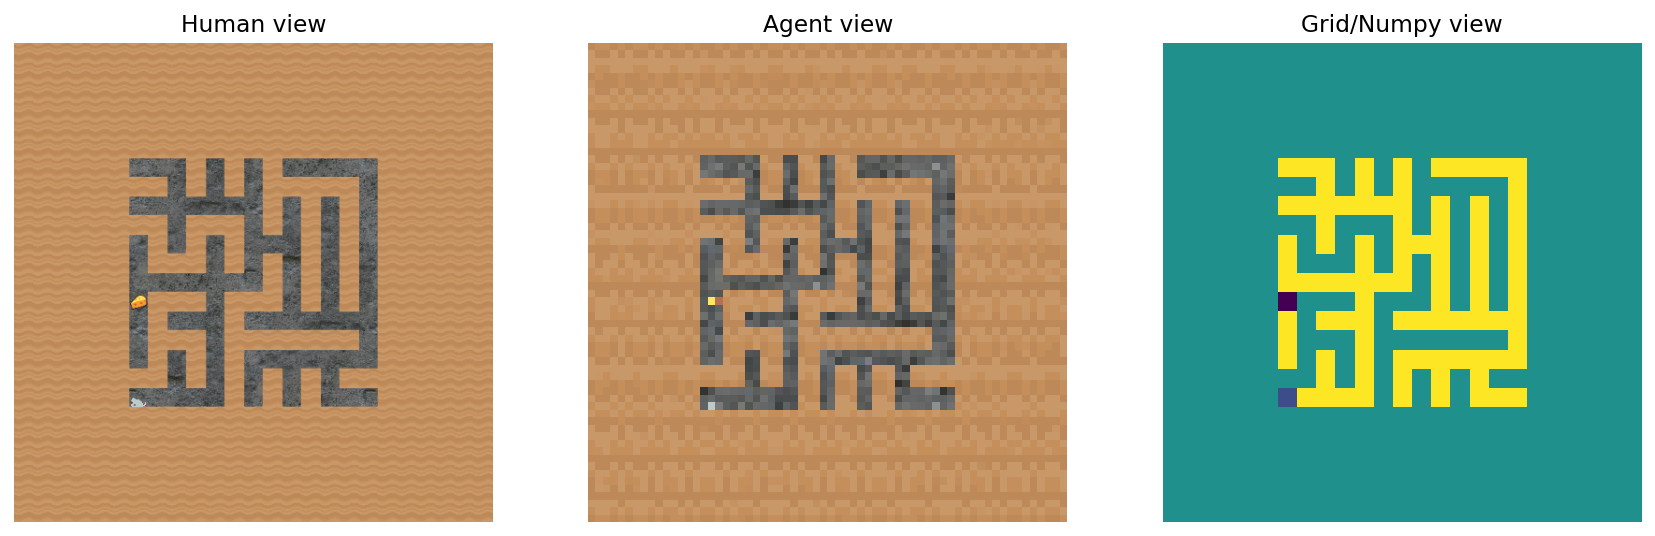

In [4]:
venv = maze.create_venv(num=1, start_level=0, num_levels=1)
fig, ax = plt.subplots(1,3, figsize=(15, 5))

human_view = venv.env.get_info()[0]['rgb']
agent_view = venv.reset()[0].transpose(1,2,0)
grid_view = maze.EnvState(venv.env.callmethod('get_state')[0]).full_grid()[::-1, :]
for (a, img, title) in zip(ax, [human_view, agent_view, grid_view], ['Human view', 'Agent view', 'Grid/Numpy view']):
    a.axis('off')
    a.imshow(img)
    a.set_title(title)

plt.show()

### Explore episodes interactively

Here you can explore a bunch of episodes from the `rand_region_5` agent, trained to get the cheese when the cheese always spawned in the top right 5x5 region of the maze.
These mazes were generated with the cheese in any position though, so there's a conflict between the "top-right shard" and the "cheese shard"

In [5]:
from procgen_tools import maze
from circrl.rollouts import load_saved_rollout
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider
from procgen_tools import vfield
import procgen_tools.vfield_stats as vs


# rand_region_5 model on all mazes, load 100 (uses a lot of memory)
files = glob('../episode_data/20230131T032642/*.dat')[:100]
rollouts = [load_saved_rollout(f) for f in tqdm(files)]

from procgen_tools.maze import EnvState
from ipywidgets import interact, IntSlider

episode_slider = IntSlider(min=0, max=len(rollouts)-1, step=1, value=0)
timestep_slider = IntSlider(min=0, max=256, step=1, value=0)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.close()
ax.set_xticks([])
ax.set_yticks([])

@interact
def show_episodes(ep = episode_slider, timestep = timestep_slider):
    timestep_slider.max = len(rollouts[ep]['seq'].obs)-1
    state = EnvState(rollouts[ep]['seq'].custom['state_bytes'][timestep].item())
    human_view = maze.render_inner_grid(state.inner_grid())
    ax.imshow(human_view)
    display(fig)
    

100%|██████████| 100/100 [00:00<00:00, 177.04it/s]


interactive(children=(IntSlider(value=74, description='ep', max=99), IntSlider(value=0, description='timestep'…

### The vector field view

A nicer way to view episodes is with a **vector field view**, which overlays a vector-field representing the agent policy for a given maze, and are computed as follows:

1. Take the output probabilities from the policy $(p_{\text{left}}, p_{\text{right}}, p_{\text{up}}, p_{\text{down}})$ at every mouse position
2. Compute the x and y components of the vector as $x = p_{\text{right}} - p_{\text{left}}$ and $y = p_{\text{down}} - p_{\text{up}}$


Generating the vector fields is a bit slow (~1s/each), so we'll load them from a precomputed dataset.

In [6]:
vfields = [pickle.load(open(f, 'rb')) for f in glob('../data/vfields/seed-*.pkl')]
vfields_by_level = defaultdict(list)
for vf in vfields:
    vfields_by_level[vf['seed']].append(vf)
def get_vfields(seed: int, coeff: float):
    return next(vf for vf in vfields_by_level[seed] if vf['coeff'] == coeff)

In [7]:
@interact(seed=IntSlider(min=0, max=max(vf['seed'] for vf in vfields), step=1, value=0))
def interact_vfields(seed: int):
    vfield.plot_vf(vfields_by_level[seed][0]['original_vfield'])

interactive(children=(IntSlider(value=0, description='seed', max=99), Output()), _dom_classes=('widget-interac…

## Model editing: Finding a "cheese" vector

"What's the stupidest first thing we could try? What if taking the difference in activations at a certain layer gave us a "cheese" vector? Could we subtract this from the activations to make the mouse ignore the cheese?"

Surprisingly, this (sort-of) works. Take a maze, make a copy with no cheese, record the difference in activations at a particular layer (`embedder.block2.res1.resadd_out` seemed to work best in our experiments though we don't yet understand why), then patch the network by adding (or subtracting) this difference to the activations at that layer.

Note that the activation vector is _fixed_ across forward passes within a level. So, while the network trivially outputs logits as if there were no cheese when given the _original_ observation (mouse in bottom-left corner), we keep using the same activation vector for the rest of the trajectory

### Interactively explore the effect of the cheese vector

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from glob import glob
from collections import defaultdict

In [9]:
vfields = [pickle.load(open(f, 'rb')) for f in glob('../data/vfields/seed-*.pkl')]
vfields_by_level = defaultdict(list)
for vf in vfields:
    vfields_by_level[vf['seed']].append(vf)
def get_vfields(seed: int, coeff: float):
    return next(vf for vf in vfields_by_level[seed] if vf['coeff'] == coeff)

In [10]:
from ipywidgets import interact, IntSlider, FloatSlider


def _coeffs_for(seed: int):
    return sorted(set(vf['coeff'] for vf in vfields_by_level[seed]))


seed_max = max(vf['seed'] for vf in vfields)
min_coeff, max_coeff = min(vf['coeff']
                           for vf in vfields), max(vf['coeff']
                                                   for vf in vfields)


@interact(seed=IntSlider(min=0, max=seed_max, step=1, value=0),
          coeff=FloatSlider(min=min_coeff, max=max_coeff, step=0.1, value=-1.0))
def interact_vfields(seed: int, coeff: float):
    # set coeff to nearest available in vfields_by_level[seed]
    coeff = min(_coeffs_for(seed), key=lambda x: abs(x - coeff))
    vfs = get_vfields(seed, coeff)
    vs.plot_vfs(vfs)

interactive(children=(IntSlider(value=0, description='seed', max=99), FloatSlider(value=-1.0, description='coe…

### Quantifying the effect of subtracting the "cheese vector"


To see the statistical change in propensity to go to the cheese, we can look at the probability of going to the cheese when there's a fork in the maze, with cheese on one side and the top-right on the other. Plotting the difference in action probabilities gives us the following:

(Note: We're *subtracting* the cheese vector, so the probability of going to the cheese should be lower, and the probability of going to the top right (or towards neither) should be higher.)

In [11]:
from ipywidgets import Dropdown

@interact
def boxplot_interactive(coeff = Dropdown(options=_coeffs_for(0), value=-1.0)):
    """ Plot boxplots of decision probabilities, given a cheese vector coefficient. """
    dprobs_original, dprobs_patched = vs.get_decision_probs_original_and_patched(vfields, coeff=coeff)
    probs_original, probs_patched = [np.stack([dprobs[:,0], dprobs[:,1], 1-dprobs[:,0]-dprobs[:,1]], axis=1) for dprobs in (dprobs_original, dprobs_patched)] # convert to 3-class probs

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        ax[i].boxplot([probs_original[:,i], probs_patched[:,i]], showmeans=True, meanline=True)
        ax[i].set_xticks([1, 2])
        # Reverse the x-axis so that it goes from 0 to 1
        ax[i].set_xticklabels(['original', 'patched'])
        ax[i].set_title([f'P({label} | decision-square)' for label in ('cheese', 'top-right', 'other')][i])


    vs.plot_decision_probs(dprobs_original, dprobs_patched)

interactive(children=(Dropdown(description='coeff', index=3, options=(-3, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, …

### What about generalization?

We're doing something quite specific here, taking in the maze `M`, recording activations, editing it to have no cheese, recording activations, and then subtracting the two. If we're truly finding a "cheese vector / cheese abstraction", we'd be able to generalize from one maze to another, and create a saved copy of the model which ignores the cheese in any maze.

In [12]:
from patch_utils import *
from procgen_tools import models
import torch as t
import circrl.module_hook as cmh

policy = models.load_policy(f'../trained_models/maze_I/model_rand_region_5.pth', 15, t.device('cpu'))
label = 'embedder.block2.res1.resadd_out'
hook = cmh.ModuleHook(policy)

value_seed = 0 # seed for the cheese vector
values = cheese_diff_values(value_seed, label, hook)
@interact
def generalization_test(seed=IntSlider(min=1, max=20, step=1, value=1)):
    plot_patched_vfield(seed=seed, coeff=-1, label=label, hook=hook, values=values, show_title=False)

/home/turneale/miniconda3/envs/MATS/lib/python3.10/site-packages/circrl/module_hook.py:220: UserWarning: Function probe_with_input is deprecated due to
        a confusing name and has been replaced with run_with_input.
  warnings.warn('''Function probe_with_input is deprecated due to


interactive(children=(IntSlider(value=1, description='seed', max=20, min=1), Output()), _dom_classes=('widget-…

Little changes when we try to transfer! Similar results hold when we average the cheese vectors from a range of levels:

In [13]:
values = np.zeros_like(cheese_diff_values(0, label, hook))
seeds = slice(int(10e5),int(10e5+100))

# Iterate over range specified by slice
for seed in range(seeds.start, seeds.stop):
    # Make values be rolling average of values from seeds
    values = (seed-seeds.start)/(seed-seeds.start+1)*values + cheese_diff_values(seed, label, hook)/(seed-seeds.start+1)

# Assumes a fixed venv, hook, values, and label
@interact
def interactive_patching(seed=IntSlider(min=0, max=20, step=1, value=0)):
    fig, _, _ = plot_patched_vfield(seed, coeff=-1, label=label, hook=hook, values=values)
    plt.show()

interactive(children=(IntSlider(value=0, description='seed', max=20), Output()), _dom_classes=('widget-interac…

So, what's happening? Another clue is that adding the cheese vector doesn't do much, either (even when we aren't transferring the vector across mazes). If we were adding "global cheese motivation" to the agent, that should increase the probability that the agent gets cheese. Consider the box-plots when coeff=1 (that is, we are _adding_ the cheese vector).

In [21]:
from ipywidgets import fixed 

_ = interact(boxplot_interactive, coeff=fixed(1.0))

interactive(children=(Output(),), _dom_classes=('widget-interact',))

Adding the vector has basically no effect. If we were adding or subtracting a "do I feel like going to the cheese rn" vector, adding the cheese vector would increase the probability of getting cheese (the "opposite" effect of subtracting the cheese vector).

## Red-team: noise baseline
What if we're just adding some meaningless vector which makes the agent go right and up more, and this, as an artifact, makes the patched network get cheese less often and go to top-right more often? The most aggressive version of this hypothesis is false, by inspection of the patched vector fields. But we'd still like to compare with random noise, to get a feel for how sensitive the network is.

Let's see what happens when we patch the network from a fixed seed. We'll compare the vector field for the original and patched networks.

In [14]:
from patch_utils import *
from procgen_tools import models
import torch as t
import circrl.module_hook as cmh

policy = models.load_policy(f'../trained_models/maze_I/model_rand_region_5.pth', 15, t.device('cpu'))
label = 'embedder.block2.res1.resadd_out'
hook = cmh.ModuleHook(policy)

rand_magnitude = .25
for mode in ['random', 'cheese']:
    vectors = []
    for value_seed in range(10):
        if mode == 'random':
            vectors.append(np.random.randn(*cheese_diff_values(0, label, hook).shape, ) * rand_magnitude)
        else:
            vectors.append(cheese_diff_values(value_seed, label, hook))
        
    norms = [np.linalg.norm(v) for v in vectors]
    print(f'For {mode}-vectors, the norm is {np.mean(norms):.2f} with std {np.std(norms):.2f}. Max absolute-value difference of {np.max(np.abs(vectors)):.2f}.')

For random-vectors, the norm is 63.99 with std 0.21. Max absolute-value difference of 1.19.
For cheese-vectors, the norm is 47.40 with std 4.18. Max absolute-value difference of 1.23.


In [15]:
values = np.random.randn(*cheese_diff_values(0, label, hook).shape) * rand_magnitude
values = values.astype(np.float32)
@interact
def run_seed_interactive(seed = IntSlider(min=0, max=20, step=1, value=0)):
    run_seed(seed, hook, [-1], values_tup=(values, 'garbage'))

interactive(children=(IntSlider(value=0, description='seed', max=20), Output()), _dom_classes=('widget-interac…

The random vector destroys performance globally, turning the patched policy into garbage. In contrast, the cheese patch either locally affects cheese-seeking behavior, or doesn't do anything at all. 

## Are we ablating ability to see cheese?
This is our current best guess. Some evidence is that, when we transfer from maze `A` with cheese at position `(row, col)`, to maze `B` with cheese also at visual field position `(row, col)`, the transfer usually works. 